In [456]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import cartopy as cp
from matplotlib.patches import FancyArrowPatch
from scipy.ndimage import map_coordinates
import metpy.calc as mpcalc
from geographiclib.geodesic import Geodesic
from utils_datetime import *

This script calculates the displacement vector fields between outlook and pph probability fields, using optical flow tracking algorithms

In [467]:
pph = xr.open_dataset('data/pph/labelled_pph.nc')
outlooks = xr.open_dataset('data/outlooks/grid_outlooks.nc')

In [462]:
# TODO: fix times so can be run from all_pph

In [501]:
geod = Geodesic.WGS84

def flow_day(outlook_array, pph_array, lons, lats):
    # returns arrays of x-flow and y-flow (units of grid squares), ending lon and lat, and east/west components of flow (units of m)
    # plots use end lon/lat, divergence uses grid square units, shifts use east/west components
    end_lons = np.empty_like(outlook_array)
    end_lats = np.empty_like(outlook_array)
    e_flow = np.empty_like(outlook_array)
    n_flow = np.empty_like(outlook_array)
    flow = cv.calcOpticalFlowFarneback(outlook_array, pph_array, None, .5, 3, 3, 3, 7, 1.5, 0)
    for i in range(lons.shape[0]):
        for j in range(lats.shape[1]):
            end_lon = map_coordinates(lons, [[i + flow[i, j, 1]], [j + flow[i, j, 0]]])
            end_lat = map_coordinates(lats, [[i + flow[i, j, 1]], [j + flow[i, j, 0]]])
            if end_lon == 0:
                end_lon = lons[i, j]
            if end_lat == 0:
                end_lat = lats[i, j]
            end_lons[i, j] = end_lon
            end_lats[i, j] = end_lat
            g = geod.Inverse(lats[i, j], lons[i, j], end_lat, end_lon)
            dist = g['s12']
            azimuth = g['azi1']
            e_flow[i, j] = dist * np.sin(np.deg2rad(azimuth))
            n_flow[i, j] = dist * np.cos(np.deg2rad(azimuth))

    return(flow[..., 0], flow[..., 1], end_lons, end_lats, e_flow, n_flow)

# TODO: call flow_day for each day (and each hazard type) within this file and save results to an xarray dataset. 
# Then add labelling function that adds EW shift, NS shift, and divergence
# Rerun explore subsets and clustering, add clustering by new labels, add spatial shift plot to explore_date

In [469]:
hazard_types= ['Wind', 'Hail', 'Tornado', 'All Hazard']
displacement_dataset = xr.Dataset(
    data_vars=dict(
        lat=(['y', 'x'], pph['lat'].data),
        lon=(['y', 'x'], pph['lon'].data)
    ),
    coords=dict(
        time=(['time'], pph['time'].data),
        x=(['x'], pph['x'].data),
        y=(['y'], pph['y'].data),
        hazard=(['hazard'], hazard_types)
    ),
    attrs=dict(description="Displacements from gridded day 1 probabilistic outlooks to gridded probabilistic PPH using Farnebeck optical flow",
            grid = pph.grid),
)

displacement_dataset = displacement_dataset.assign(x_flow = (('time', 'y', 'x', 'hazard'), np.full((len(displacement_dataset['time']), len(displacement_dataset['y']), len(displacement_dataset['x']), len(hazard_types)), 0.0)))
displacement_dataset = displacement_dataset.assign(y_flow = (('time', 'y', 'x', 'hazard'), np.full((len(displacement_dataset['time']), len(displacement_dataset['y']), len(displacement_dataset['x']), len(hazard_types)), 0.0)))
displacement_dataset = displacement_dataset.assign(end_lon = (('time', 'y', 'x', 'hazard'), np.full((len(displacement_dataset['time']), len(displacement_dataset['y']), len(displacement_dataset['x']), len(hazard_types)), 0.0)))
displacement_dataset = displacement_dataset.assign(end_lat = (('time', 'y', 'x', 'hazard'), np.full((len(displacement_dataset['time']), len(displacement_dataset['y']), len(displacement_dataset['x']), len(hazard_types)), 0.0)))
displacement_dataset = displacement_dataset.assign(e_flow = (('time', 'y', 'x', 'hazard'), np.full((len(displacement_dataset['time']), len(displacement_dataset['y']), len(displacement_dataset['x']), len(hazard_types)), 0.0)))
displacement_dataset = displacement_dataset.assign(n_flow = (('time', 'y', 'x', 'hazard'), np.full((len(displacement_dataset['time']), len(displacement_dataset['y']), len(displacement_dataset['x']), len(hazard_types)), 0.0)))


In [487]:
pph_key_dict = {
    'Wind': 'p_perfect_wind',
    'Hail': 'p_perfect_hail',
    'Tornado': 'p_perfect_tor',
    'All Hazard': 'p_perfect_max'
}

outlook_key_dict = {
    'Wind': 'Day 1 Wind',
    'Hail': 'Day 1 Hail',
    'Tornado': 'Day 1 Tornado',
    'All Hazard': 'Day 1'
}

In [539]:
lons =  pph.lon.values
lats = pph.lat.values
oldyear = 0

for time in displacement_dataset['time'][displacement_dataset['time'] >= '200203310000']:
    year = str(time.values)[:6]
    if year != oldyear:
        displacement_dataset.to_netcdf('data/displacement/displacements.nc')
        oldyear = year
        print(year)
    for hazard in hazard_types:
        pph_array = pph.sel(time = time)[pph_key_dict[hazard]].data*2.55 # normalize to 8-bit image scale
        outlook_array = outlooks.sel(time = time, outlook = outlook_key_dict[hazard])['prob'].data*255 # normalize to 8-bit image scale
        x_flow, y_flow, end_lons, end_lats, e_flow, n_flow = flow_day(outlook_array, pph_array, lons, lats)

        displacement_dataset['x_flow'].loc[dict(time = time, hazard = hazard)] = x_flow
        displacement_dataset['y_flow'].loc[dict(time = time, hazard = hazard)] = y_flow
        displacement_dataset['end_lon'].loc[dict(time = time, hazard = hazard)] = end_lons
        displacement_dataset['end_lat'].loc[dict(time = time, hazard = hazard)] = end_lats
        displacement_dataset['e_flow'].loc[dict(time = time, hazard = hazard)] = e_flow
        displacement_dataset['n_flow'].loc[dict(time = time, hazard = hazard)] = n_flow
    

displacement_dataset.to_netcdf('data/displacement/displacements.nc')

200203
200204
200205
200206
200207
200208
200209
200210
200211
200212
200301
200302
200303
200304
200305
200306
200307
200308
200309
200310
200311
200312
200401
200402
200403
200404
200405
200406
200407
200408
200409
200410
200411
200412
200501
200502
200503
200504
200505
200506
200507
200508
200509
200510
200511
200512
200601
200602
200603
200604
200605
200606
200607
200608
200609
200610
200611
200612
200701
200702
200703
200704
200705
200706
200707
200708
200709
200710
200711
200712
200801
200802
200803
200804
200805
200806
200807
200808
200809
200810
200811
200812
200901
200902
200903
200904
200905
200906
200907
200908
200909
200910
200911
200912
201001
201002
201003
201004
201005
201006
201007
201008
201009
201010
201011
201012
201101
201102
201103
201104
201105
201106
201107
201108
201109
201110
201111
201112
201201
201202
201203
201204
201205
201206
201207
201208
201209
201210
201211
201212
201301
201302
201303
201304
201305
201306
201307
201308
201309
201310
201311
201312
201401

In [527]:
test_date = '201104270000'
pph_array = pph.sel(time = test_date)['p_perfect_tor'].data/100*255 # normalize to 8-bit image scale
outlook_array = outlooks.sel(time = test_date, outlook = 'Day 1 Tornado')['prob'].data*255 # normalize to 8-bit image scale
x_flow, y_flow, end_lons, end_lats, e_flow, n_flow = flow_day(outlook_array, pph_array, pph.lon.values, pph.lat.values)

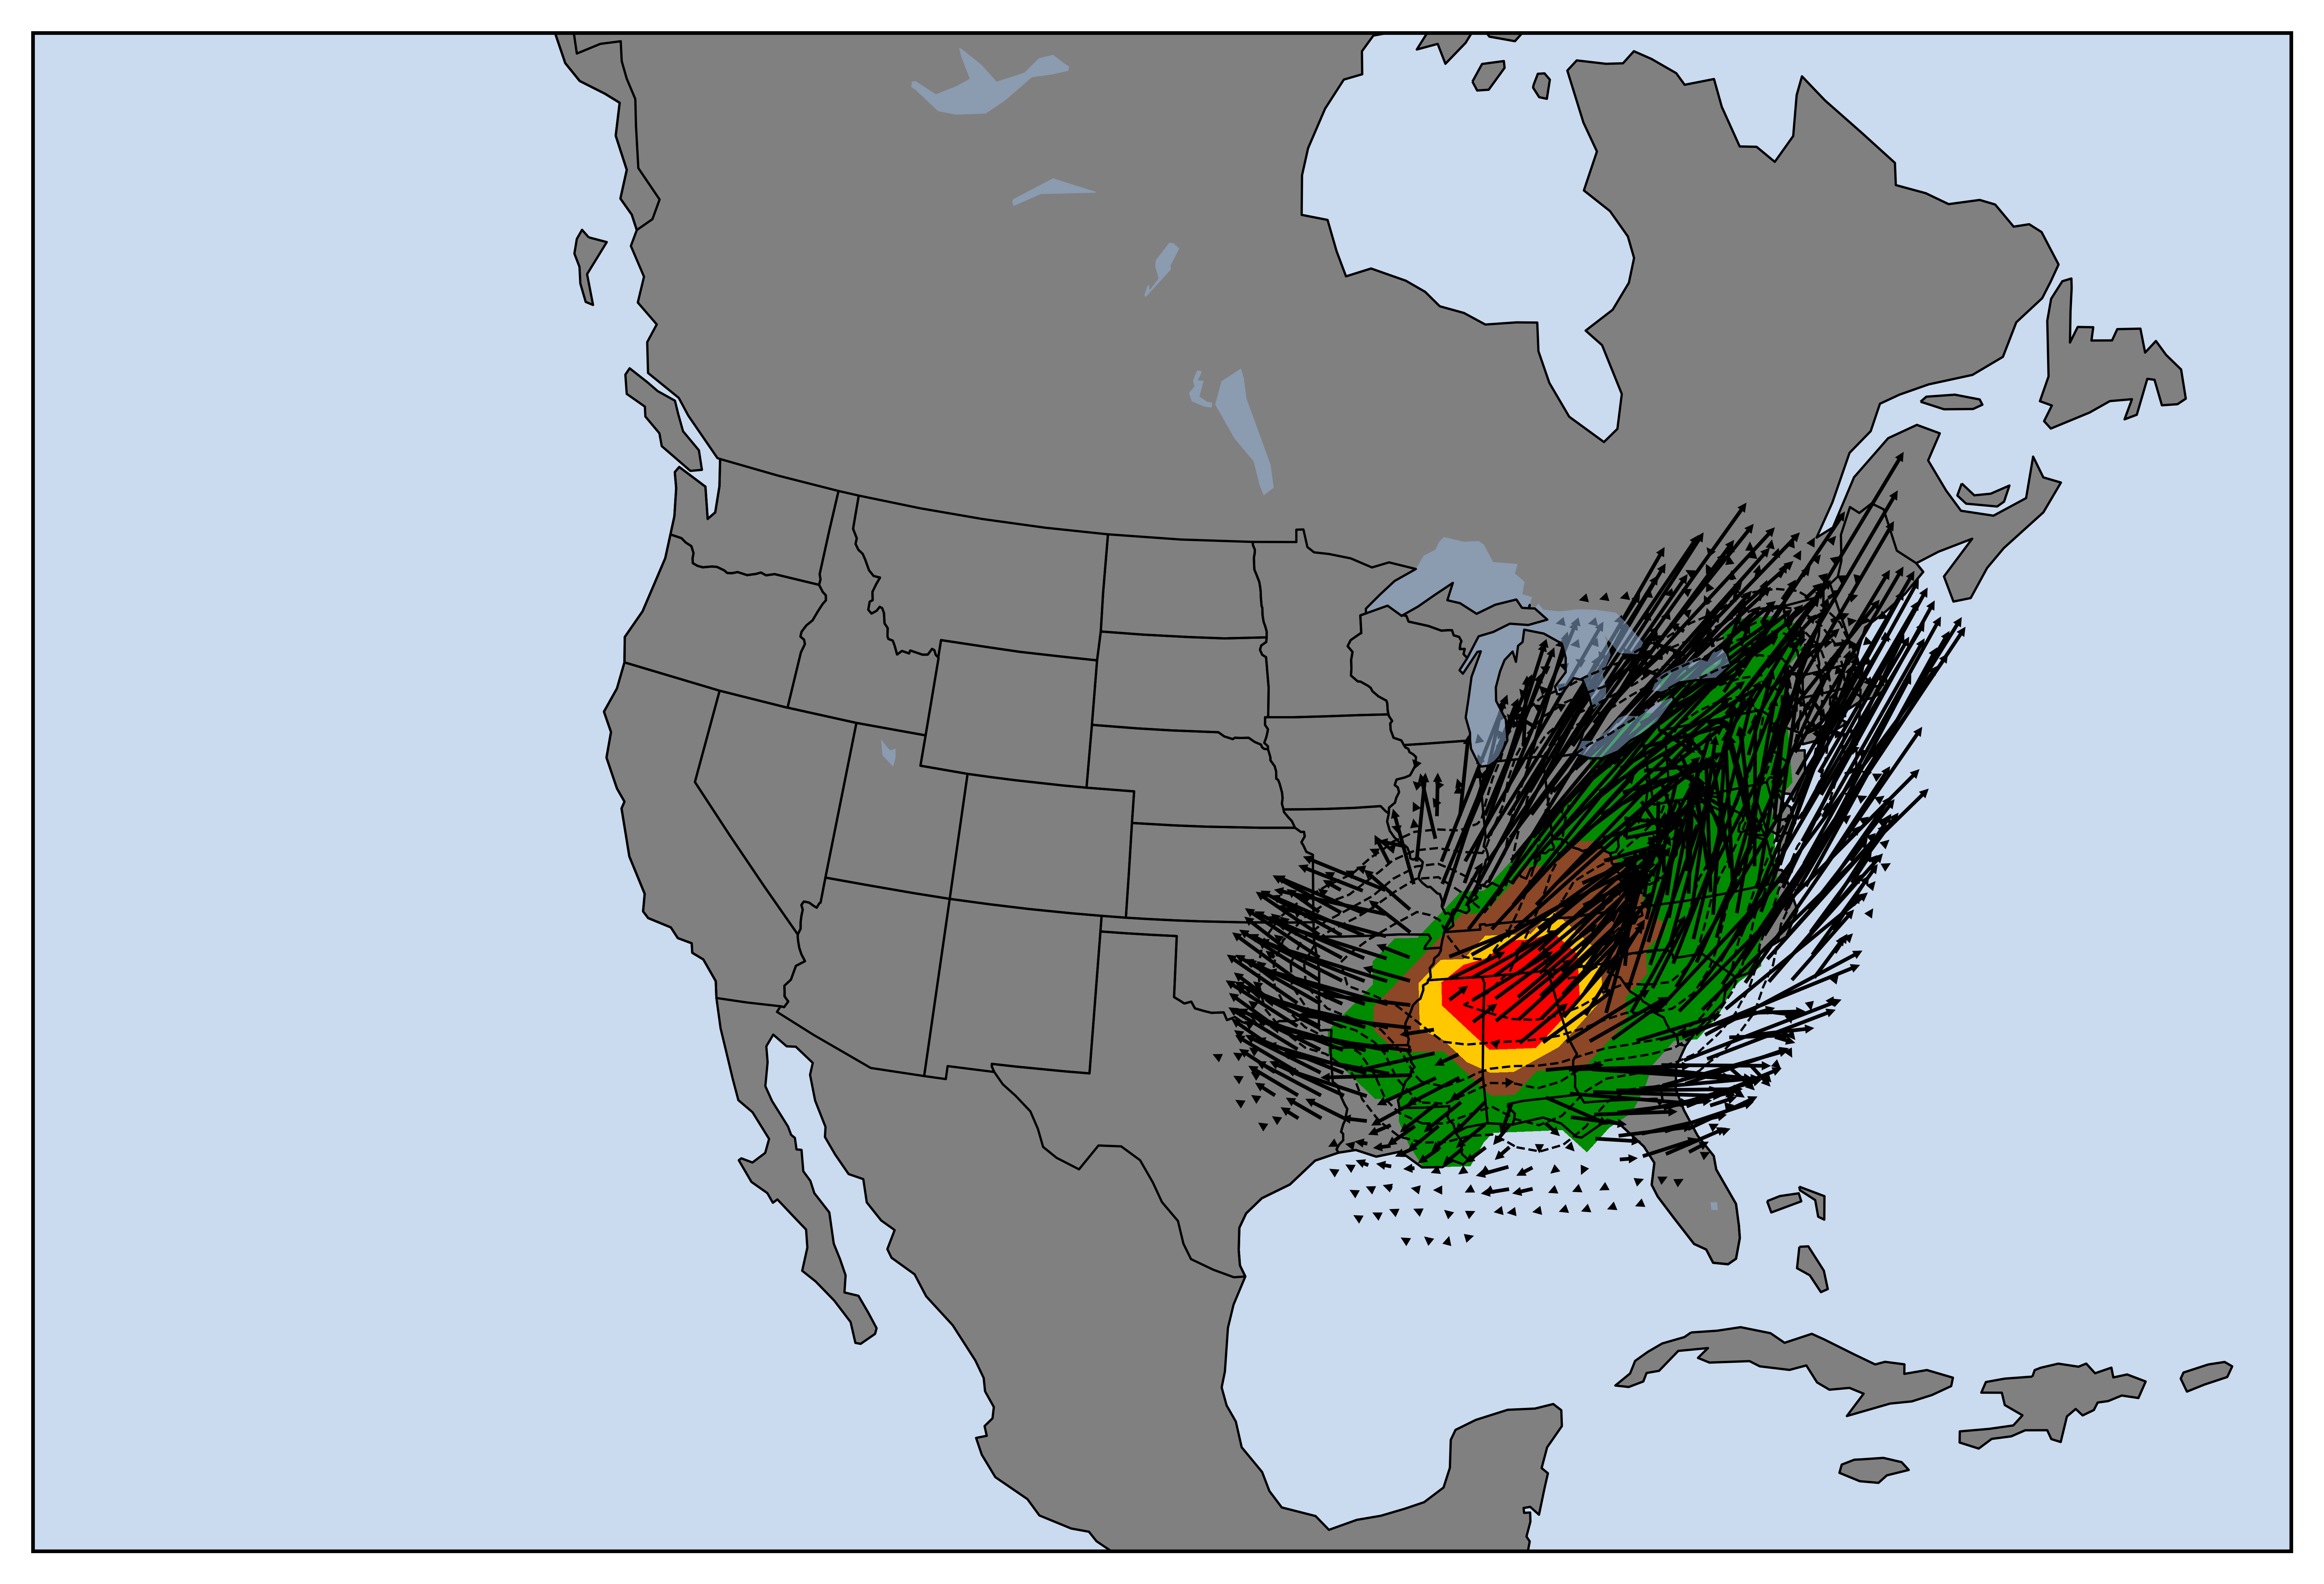

In [528]:
lons = pph.lon.values
lats = pph.lat.values

fig=plt.figure(figsize=(9,6), dpi = 1000)
ax = plt.axes(projection = cp.crs.LambertConformal())
ax.add_feature(cp.feature.LAND,facecolor='grey')
ax.add_feature(cp.feature.OCEAN, alpha = 0.5)
ax.add_feature(cp.feature.COASTLINE,linewidth=0.5)
ax.add_feature(cp.feature.LAKES, alpha = 0.5)
ax.add_feature(cp.feature.STATES,linewidth=0.5)
ax.contourf(lons, lats, outlook_array/255,
                    levels=[.02,.05,.10,.15,.30,.45,.60,1.00], colors=['#008b00','#8b4726','#ffc800', '#ff0000', '#ff00ff', '#912cee', '#104e8b'], transform=cp.crs.PlateCarree())
ax.contour(lons, lats, pph_array/255, levels=[.02,.05,.10,.15,.30,.45,.60,1.00], colors = 'black', linestyles = 'dashed', linewidths = .5, transform=cp.crs.PlateCarree())

for i in range(lons.shape[0]):
    for j in range(lats.shape[1]):
        if np.abs(x_flow[i, j]) > .01 and np.abs(y_flow[i, j]) > .01:
            ax.add_patch(FancyArrowPatch((lons[i, j], lats[i, j]), (end_lons[i, j], end_lats[i, j]), transform=cp.crs.PlateCarree(), color = 'black', mutation_scale=4, linewidth = .01))

In [524]:
outlooks.sel(time = '200204260000', outlook = 'Day 1 Tornado')['prob'].max()

<xarray.DataArray 'prob' ()>
array(0.05)
Coordinates:
    time     <U12 '200204260000'
    outlook  <U13 'Day 1 Tornado'

In [406]:
# TODO: handle weights properly when all zero... think about how to do still
# weighted mean shift
x_shift = np.average(flow[:, :, 0], weights = outlook_array)
y_shift = np.average(flow[:, :, 1], weights = outlook_array)
x_shift*80, y_shift * 80


(-71.99934845430809, -1.5968921358495602)

In [407]:
# weighted mean divergence, range should be approximately (-1, 1)
# try basic method with np.gradient. Will then use metpy gradient but need flow vectors to have proper units first

div = np.gradient(flow[:, :, 0])[1] + np.gradient(flow[:, :, 1])[0]
total_div = np.average(div, weights = outlook_array)
total_div


curl = np.gradient(flow[:, :, 0])[0] + np.gradient(flow[:, :, 1])[1]
total_curl = np.average(curl, weights = outlook_array)

total_div

0.3217408539868935

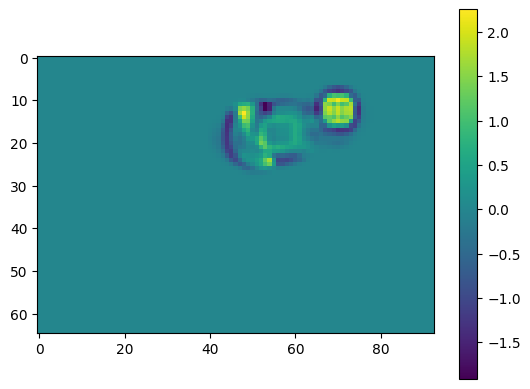

In [408]:
plt.imshow(div)
plt.colorbar()